In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, roc_curve, matthews_corrcoef

print("Loading libraries and starting...")

# Load the dataset
df = pd.read_csv('merged_data_clean.csv')
# df = df[df['Source'] == 'MolToxPred']
print("Initial dataset loaded")
print(df.head(10))
print("Dataset shape:", df.shape)

# Store categorical columns and drop them
categorical_columns = ['SMILES', 'Source']
df = df.drop(columns=categorical_columns)
print("Dataset after dropping categorical columns")
print(df.head(10))

Y = df['Toxicity']

X_pca_df = pd.read_csv('X_pca_clean.csv')
print("PCA DataFrame shape:", X_pca_df.shape)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_df, Y, test_size=0.2, random_state=42, shuffle=True, stratify=Y)
print("Data split into train and test sets")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Check GPU availability
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Define the model
model = Sequential()

model.add(Dense(512, input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print("Model compiled")

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
print("Training the model...")
history = model.fit(X_train, Y_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1, callbacks=[reduce_lr, early_stopping])

# Evaluate the model
print("Evaluating the model on test data...")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Make predictions
print("Making predictions on test data...")
Y_pred_prob = model.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int)

2024-07-02 16:12:26.660973: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 16:12:26.661479: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 16:12:26.665553: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 16:12:26.714712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 16:12:27.728916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Loading libraries and starting...


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [2]:
# Calculate additional metrics
f1 = f1_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
mcc = matthews_corrcoef(Y_test, Y_pred)

print("F1 Score: ", f1)
print("Confusion Matrix: \n", cm)
print("Classification Report: \n", cr)
print("ROC AUC Score: ", roc_auc)
print("Precision: ", precision)
print("Recall: ", recall)
print("Matthews Correlation Coefficient: ", mcc)
print("accuracy_score: ", accuracy_score(Y_test, Y_pred))

F1 Score:  0.834257975034674
Confusion Matrix: 
 [[1132  171]
 [ 307 1203]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.79      0.87      0.83      1303
         1.0       0.88      0.80      0.83      1510

    accuracy                           0.83      2813
   macro avg       0.83      0.83      0.83      2813
weighted avg       0.83      0.83      0.83      2813

ROC AUC Score:  0.8994836165141065
Precision:  0.8755458515283843
Recall:  0.7966887417218543
Matthews Correlation Coefficient:  0.6638262032542701
accuracy_score:  0.830074653394952


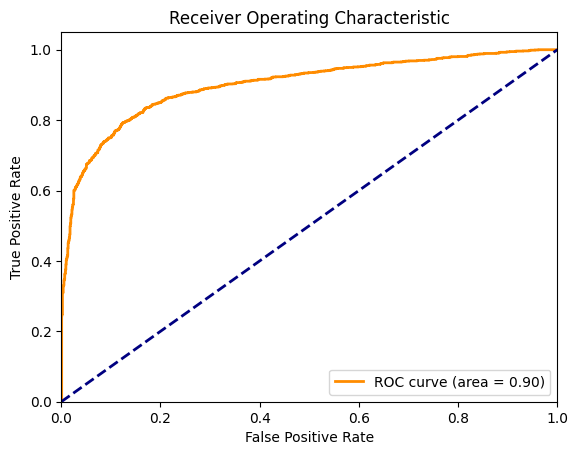

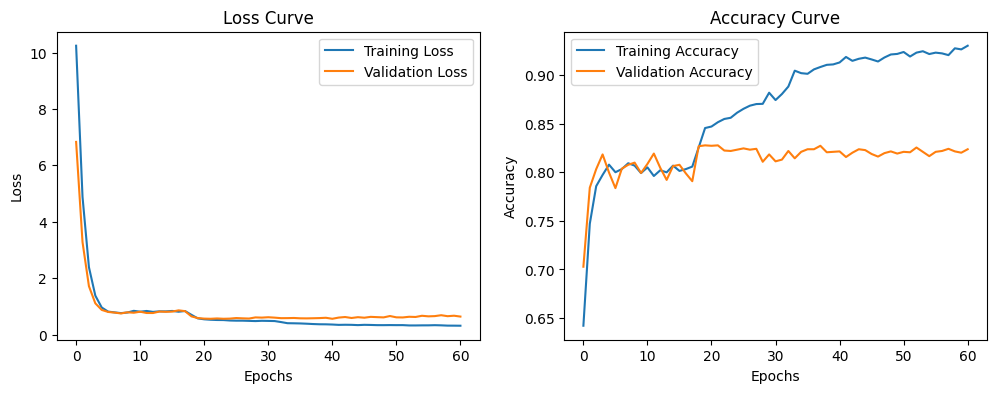

In [3]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()